<a href="https://colab.research.google.com/github/ab2gbl/Master2/blob/main/AAI/TP/AAI_TP6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2

import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.saving import save_model,load_model
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , BatchNormalization , Dropout
from keras.utils import to_categorical
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np



In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


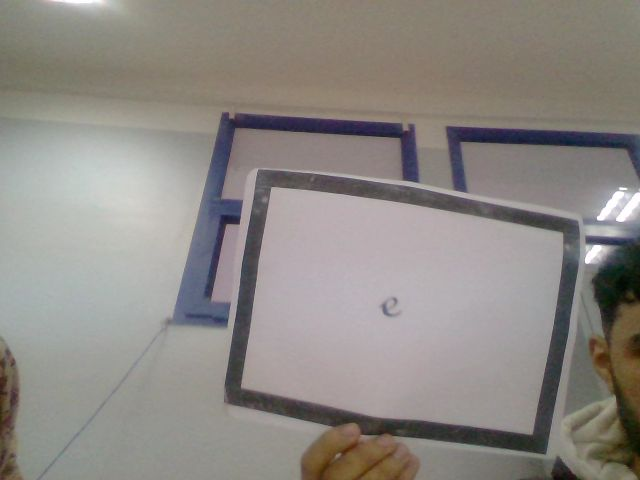

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

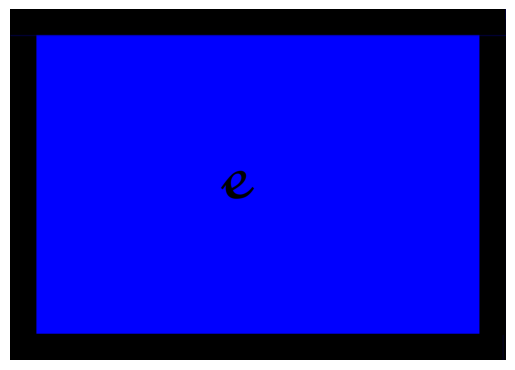

In [ ]:
image=cv2.imread('photo.jpg')
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(image_hsv)
plt.axis('off')
plt.show()

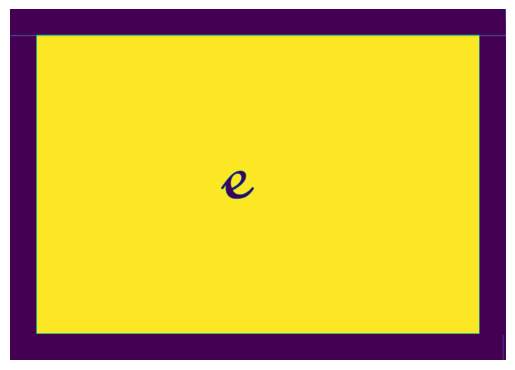

In [ ]:

v_channel = image_hsv[:, :, 2]
plt.imshow(v_channel)
plt.axis('off')
plt.show()

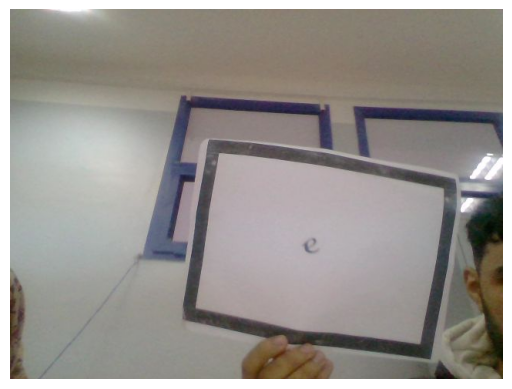

In [ ]:
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_RGB)
plt.axis('off')
plt.show()

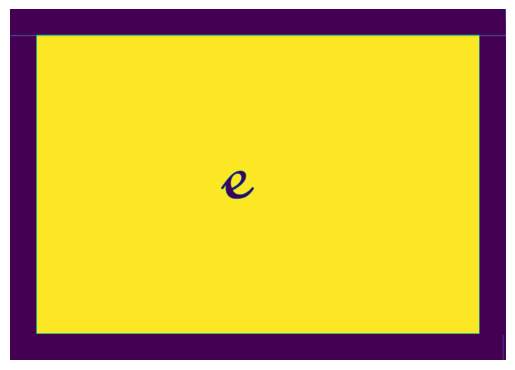

In [ ]:
image_gray_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray_rgb)
plt.axis('off')
plt.show()

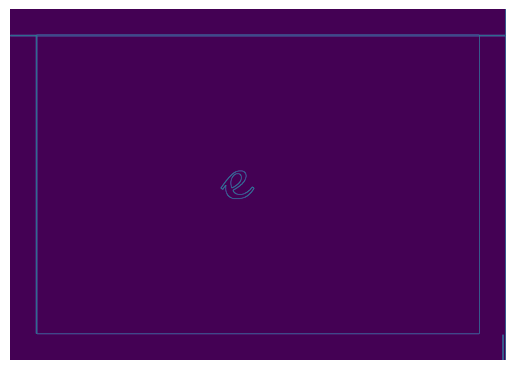

In [ ]:
edges_rgb = cv2.Canny(v_channel, threshold1=100, threshold2=200)
plt.imshow(edges_rgb)
plt.axis('off')
plt.show()

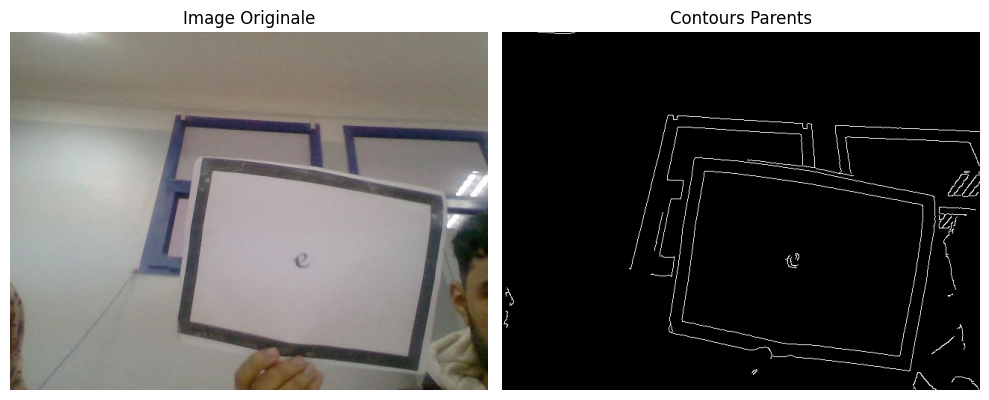

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image Originale")
plt.axis('off')

# Affichage de l'image avec les contours parents
plt.subplot(1, 2, 2)
plt.imshow(edges_rgb, cmap='gray')
plt.title("Contours Parents")
plt.axis('off')

plt.tight_layout()
plt.show()

# **Model training**

In [ ]:
import kagglehub


path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

100%|██████████| 1.24G/1.24G [00:57<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crawford/emnist/versions/3


In [ ]:

# Check the contents of the EMNIST folder
dataset_path = '/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/'
print(os.listdir(dataset_path))

NameError: name 'os' is not defined

In [ ]:


emnist_path_train = dataset_path + 'emnist-letters-train.csv'
emnist_path_test = dataset_path + 'emnist-letters-test.csv'


train_df = pd.read_csv(emnist_path_train, header=None)
test_df = pd.read_csv(emnist_path_test, header=None)
train_df.shape
test_df.shape



(14800, 785)

In [ ]:


# Paths to the CSV files
dataset_path = '/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/'
emnist_path_train = dataset_path + 'emnist-letters-train.csv'
emnist_path_test = dataset_path + 'emnist-letters-test.csv'


train_df = pd.read_csv(emnist_path_train, header=None)
test_df = pd.read_csv(emnist_path_test, header=None)


X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values


y_train = y_train - 1
y_test = y_test - 1


X_train = X_train.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=26)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=26)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")




Training data shape: (71040, 28, 28, 1)
Validation data shape: (17760, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])



model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 243,610 (951.60 KB)

 Trainable params: 243,610 (951.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7025 - loss: 0.9983 - val_accuracy: 0.9088 - val_loss: 0.2858
Epoch 2/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9184 - loss: 0.2413 - val_accuracy: 0.9241 - val_loss: 0.2301
Epoch 3/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9326 - loss: 0.1956 - val_accuracy: 0.9291 - val_loss: 0.2135
Epoch 4/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9408 - loss: 0.1641 - val_accuracy: 0.9292 - val_loss: 0.2066
Epoch 5/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9479 - loss: 0.1396 - val_accuracy: 0.9329 - val_loss: 0.2031
Epoch 6/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9537 - loss: 0.1236 - val_accuracy: 0.9320 - val_loss: 0.2096
Epoch 7/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9577 - loss: 0.1086 - val_accuracy: 0.9358 - val_loss: 0.2101
Epoch 8/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9631 - loss: 0.0947 -

In [ ]:
model2 = Sequential()

# 1- convolution layer
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))   # Rectified Linear Unit
# 2- normalization layer
model2.add(BatchNormalization())
# 3- convolution layer
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 4- normalization layer
model2.add(BatchNormalization())
# 5- Pooling
model2.add(MaxPooling2D(pool_size=(2, 2)))
# 6- dropout
model2.add(Dropout(0.25))

# 7- convolution layer
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 8- normalization layer
model2.add(BatchNormalization())
# 9- dropout
model2.add(Dropout(0.25))

# 10- convolution layer
model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 11- normalization layer
model2.add(BatchNormalization())
# 12- Pooling
model2.add(MaxPooling2D(pool_size=(2, 2)))
# 13- dropout
model2.add(Dropout(0.25))

# 14- Flatten
model2.add(Flatten())
# 15- Fully Connected Layer
model2.add(Dense(512, activation='relu'))
# 16- normalization layer
model2.add(BatchNormalization())
# 17- dropout
model2.add(Dropout(0.05))

# 18- Fully Connected Layer
model2.add(Dense(128, activation='relu'))
# 19- normalization layer
model2.add(BatchNormalization())
# 20- dropout
model2.add(Dropout(0.05))

# 21- output layer
model2.add(Dense(26, activation='softmax'))



In [ ]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             5

 Total params: 1,223,610 (4.67 MB)

 Trainable params: 1,221,818 (4.66 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:


history2 = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy2:.4f}")

Epoch 1/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7592 - loss: 0.8179 - val_accuracy: 0.9206 - val_loss: 0.2379
Epoch 2/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9157 - loss: 0.2509 - val_accuracy: 0.9328 - val_loss: 0.2001
Epoch 3/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9287 - loss: 0.2014 - val_accuracy: 0.9381 - val_loss: 0.1793
Epoch 4/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9372 - loss: 0.1762 - val_accuracy: 0.9407 - val_loss: 0.1759
Epoch 5/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9395 - loss: 0.1671 - val_accuracy: 0.9439 - val_loss: 0.1655
Epoch 6/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9438 - loss: 0.1533 - val_accuracy: 0.9424 - val_loss: 0.1708
Epoch 7/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9485 - loss: 0.1394 - val_accuracy: 0.9460 - val_loss: 0.1621
Epoch 8/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9484 - loss: 0.134

In [ ]:
model2.save('/content/drive/MyDrive/Master2/AAI/Tp6_model2.keras')

# **Model using**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Master2/AAI/Tp6_model2.keras')


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def predict_with_canny(image, model):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Extract the Value (V) channel
    v_channel = hsv_image[:, :, 2]

    edges = cv2.Canny(v_channel, threshold1=200, threshold2=256)

    resized_image = cv2.resize(edges, (28, 28))
    reshaped_image = resized_image.reshape((1, 28, 28, 1))
    normalized_image = reshaped_image / 255.0
    prediction = model.predict(normalized_image)
    predicted_class = np.argmax(prediction)
    return predicted_class


In [ ]:
import string

letters = list(string.ascii_uppercase)
image_path = 'photo.jpg'
image = cv2.imread(image_path)

p=predict_with_canny(image,model)

print('the letter in :',letters[p])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
the letter in : I


In [ ]:
!pip install gtts



In [ ]:
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class
tts = gTTS(letters[p]) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)
